# 🐨 COSADAMA Intermediate Data Science : Machine Learning week7-8

## Model 성능 개선하기
* feature engineering
* parameter tuning   


* tree 깊이 제한
* leaf node 개수 개한
* 최소한의 sample 개수 제한

## Feature Engineering   
1. outcome에 따라서 pregnancies 많으면 발병률 높고, Glucose too. 대체로 모든 수치들이 발병률 0,1과 차이가 남. Age 값이 클수록 당뇨병 발병률이 높음 age, insulin, skinThickness 수치가 범위가 넓은 편 범위가 넓으면 수치형 변수로 조건을 나눠주게 되는데 이 조건을 나누어줄 때 조건이 세부화됨.   
2. 끝 노드 보면 샘플 개수가 1,2개로 나뉘게 됨. 조건 많으면 tree 깊어지고, 깊이를 제한할 수도 있지만 feature engineering을 통해 조건을 일반화할 것임.   
3. 임신횟수는 20회 가까워질수록 없고, 모수 적은 데이터를 일반화하는게 맞니? 아니지. 샘플 개수 적은데 적은 샘플 개수로 예측하면 train data에 overfit. 과적합 현상 

### Overfitting and Underfitting   

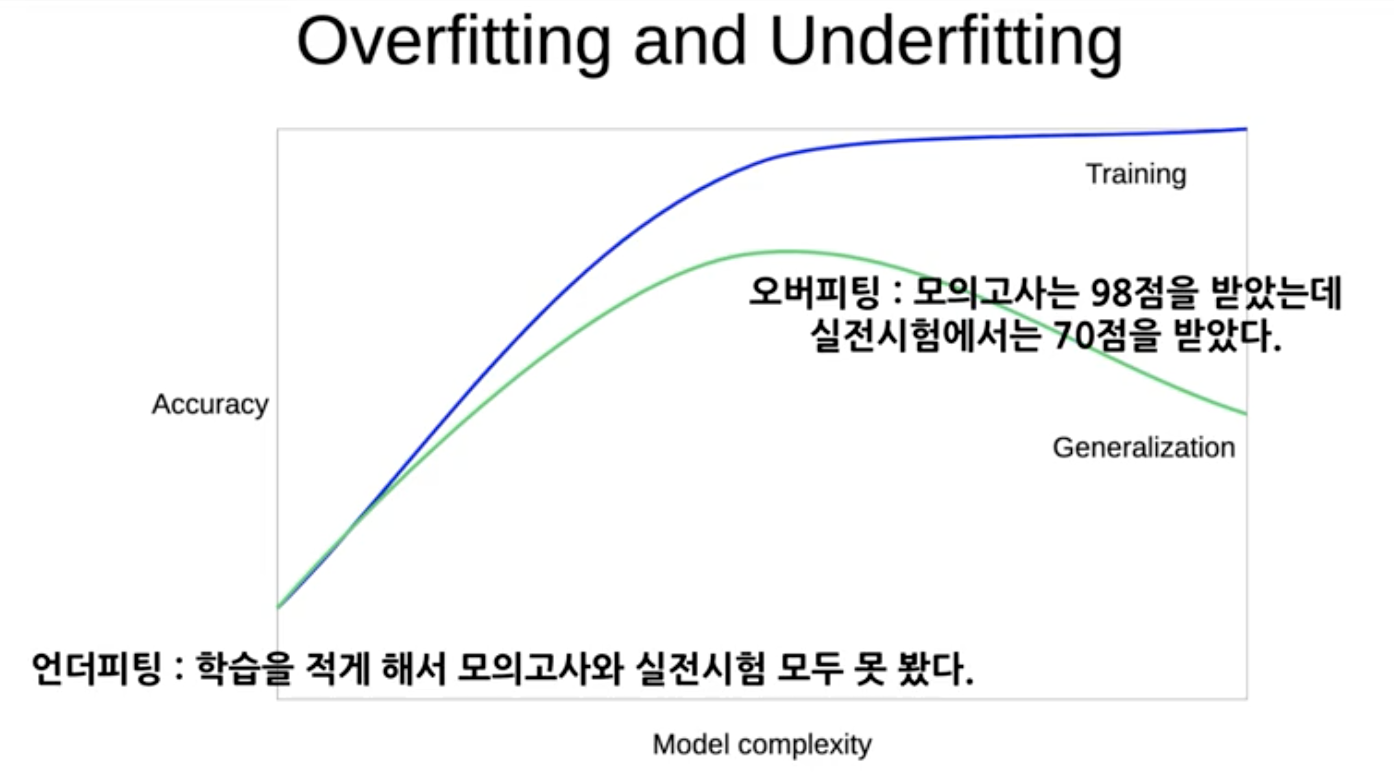

수치형 변수가 잘게 나뉘어지면 그 데이터에 overfit 현상이 발생하기 쉬움 -> 연속 수치 데이터는 범주형으로 만들어준다.   
연속된 수치 데이터를 범주형으로 만들어보자.   
pregnancies, glucose, insulin(결측치도 많고 범위도 넓음), age 손봐야할듯

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [160]:
import seaborn as sns

In [161]:
df=pd.read_csv('diabetes.csv')
df.shape # the number of data

(768, 9)

In [162]:
df.head() # outcome이 우리가 예측해야 하는

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


원래 문자나 결측치가 있으면 처리해줘야 함. 이번 데이터셋의 경우 예쁘네

## 수치형 변수를 범주형 변수로 만들기

* 임신횟수 7회가 넘어가면 발병률 높아지고, 14, 15, 17은 일반적이지 않은 수
* 범주화에 따라 성능이 달라지므로 다양한 방법을 시도해보자

### * 임신횟수

In [163]:
df['Pregnancies_high'] = df['Pregnancies'] > 6
df[['Pregnancies', 'Pregnancies_high']].head()

,Pregnancies,Pregnancies_high
0,6,False
1,1,False
2,8,True
3,1,False
4,0,False


### * Age

많고 적음이 아니라, 세 범위로 나눠본다.

age를 넣었더니 성능이 더 안 좋아짐. **WHY?????**   
30세가 넘으면 발병률이 높지만 60세 넘으면 차이가 없다. 범주화가 성능을 올릴수도 있지만 낮출수도 있음. 무조건 feature engineer 한다고 오르지 않는다. 성능이 오르는지 낮아지는지 분석을 하면서 모델의 성능을 높여야 한다. 다양한 방법을 시도해야함! 컬럼을 3개로 만듦.   

각 구간의 컬럼을 만드는 방법 = **'One-Hot-Encoding'** TF로 표시하여 만드는 방법, 수치 데이터 뿐만 아니라 low,middle,high 조건을 각 컬럼으로 만들 수 있음.   
오늘 한 방법 = 원래 수치데이터 -> 범주화 데이터 -> 수치데이터(Bool)   

범주-> 수치로 바꿀 때 많이 씀

In [164]:
df['Age']

0      50
1      31
2      32
3      21
4      33
       ..
763    63
764    27
765    30
766    47
767    23
Name: Age, Length: 768, dtype: int64

In [165]:
df['Age_low'] = df['Age'] < 25
df['Age_middle'] = (df['Age'] >= 25) & (df['Age']<=60)
df['Age_high'] = df['Age'] > 60
df[['Age', 'Age_low', 'Age_middle', 'Age_high']].head()

,Age,Age_low,Age_middle,Age_high
0,50,False,True,False
1,31,False,True,False
2,32,False,True,False
3,21,True,False,False
4,33,False,True,False


어느 정도 차이가 날까? 세 범위

<AxesSubplot:xlabel='Age_low', ylabel='count'>

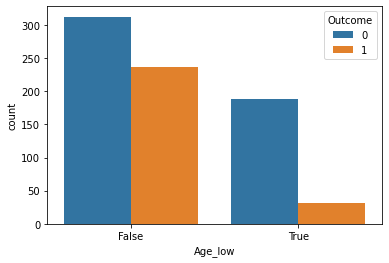

In [166]:
sns.countplot(data=df, x='Age_low', hue='Outcome')

<AxesSubplot:xlabel='Age_middle', ylabel='count'>

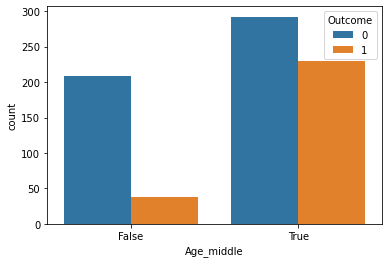

In [167]:
sns.countplot(data=df, x='Age_middle', hue='Outcome')

<AxesSubplot:xlabel='Age_high', ylabel='count'>

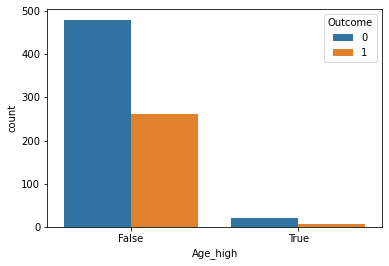

In [168]:
sns.countplot(data=df, x='Age_high', hue='Outcome') # 모수 적어

## 결측치 다루기

In [169]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Pregnancies_high            0
Age_low                     0
Age_middle                  0
Age_high                    0
dtype: int64

In [170]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [171]:
df['Insulin_nan'] = df['Insulin'].replace(0,np.nan)
df[['Insulin', 'Insulin_nan']].head()

,Insulin,Insulin_nan
0,0,NaN
1,0,NaN
2,0,NaN
3,94,94.0
4,168,168.0


In [172]:
df['Insulin_nan'].isnull().sum()

374

In [173]:
# 결측치 비율
df['Insulin_nan'].isnull().mean()

0.4869791666666667

In [174]:
df.groupby(['Outcome'])['Insulin', 'Insulin_nan'].agg(['mean', 'median']) # 결측치 처리 이후 차이?

C:\Users\Owner\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Insulin        Insulin_nan       
               mean median        mean median
Outcome                                      
0         68.792000     39  130.287879  102.5
1        100.335821      0  206.846154  169.5

In [175]:
df['Insulin_nan']

0        NaN
1        NaN
2        NaN
3       94.0
4      168.0
       ...  
763    180.0
764      NaN
765    112.0
766      NaN
767      NaN
Name: Insulin_nan, Length: 768, dtype: float64

* 결측치 채우는 방법 :
    평균값, 중앙값 차이가 많이 남, 결측치를 채워보고 성능이 잘 나오는 값으로 예측을 하면 됨

In [176]:
# 결측치 채우기
df.loc[(df['Outcome']==1) & (df['Insulin_nan'].isnull()), 'Insulin_nan'] = 169.5
df.loc[(df['Outcome']==0) & (df['Insulin_nan'].isnull()), 'Insulin_nan'] = 102.5


#위에서 구한 평균 값 채움

## 왜도, 첨도

* 왜도 : 한쪽으로 치우쳐져 있는 정도
* 첨도 : 뾰족한 정도

C:\Users\Owner\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Insulin', ylabel='Density'>

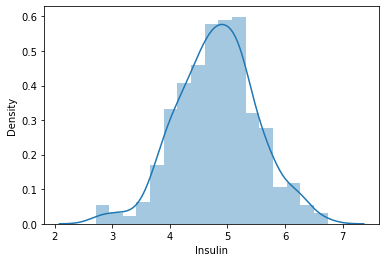

In [177]:
sns.distplot(np.log(df.loc[df['Insulin'] > 0, 'Insulin'] + 1))

log 변환을 하면 정규분포를 이룬다. 한쪽으로 데이터가 몰려있을 때보다 정규분표일 떄 조금 더 좋은 성능을 낸다.

C:\Users\Owner\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Insulin_nan', ylabel='Density'>

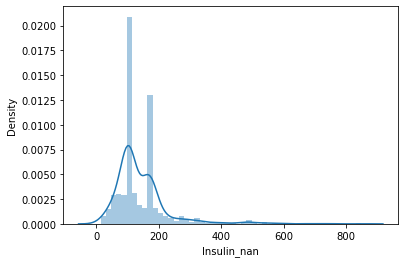

In [178]:
sns.distplot(df['Insulin_nan']) # 첨도 뾰족! 꼬리가 길고 왼쪽에 치우친 값

C:\Users\Owner\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Insulin_log', ylabel='Density'>

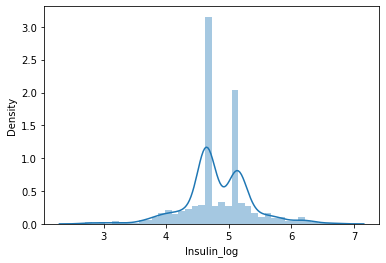

In [179]:
df['Insulin_log']=np.log(df['Insulin_nan'] + 1) # -무한대 방지
sns.distplot(df['Insulin_log'])

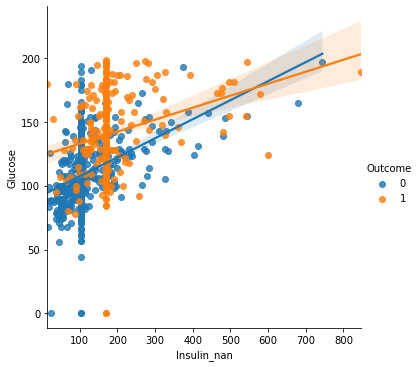

In [180]:
sns.lmplot(data=df, x="Insulin_nan", y="Glucose", hue="Outcome")

In [181]:
df['low_glu_insulin']=(df['Glucose'] < 100) & (df['Insulin_nan'] < 102.5)
df['low_glu_insulin'].head()

0    False
1    False
2    False
3     True
4    False
Name: low_glu_insulin, dtype: bool

In [182]:
pd.crosstab(df['Outcome'], df['low_glu_insulin']) #범주형 값에 대한 cross

low_glu_insulin,False,True
Outcome,,
0,418,82
1,263,5


t로 나온 값이 글루코스와 인슐린 값이 낮은 값임. t에 해당되는 값이 발병률이 낮다. 이 값이 낮을 때 확실히 발병률이 낮다는 것을 확인.

#### 이상치 다루기

C:\Users\Owner\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Insulin_nan'>

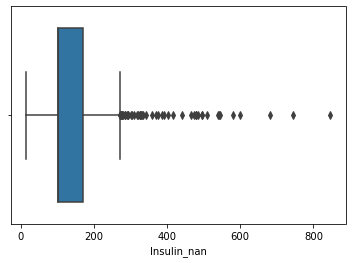

In [183]:
sns.boxplot(df['Insulin_nan'])

600이상의 이상치 발견

In [184]:
df['Insulin_nan'].describe() # nan을 중앙값으로 채워서 25와 50의 값이 같음

count    768.000000
mean     141.753906
std       89.100847
min       14.000000
25%      102.500000
50%      102.500000
75%      169.500000
max      846.000000
Name: Insulin_nan, dtype: float64

In [185]:
IQR3=df['Insulin_nan'].quantile(0.75) # 중앙값이 기본, 분위수 구하기
IQR1=df['Insulin_nan'].quantile(0.25)
IQR=IQR3-IQR1
IQR

67.0

In [186]:
OUT = IQR3 + (1.5* IQR) # 상자 수염그림에서 보는 이상치 값
OUT

270.0

In [187]:
df[df['Insulin_nan'] > OUT].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Age_low,Age_middle,Age_high,Insulin_nan,Insulin_log,low_glu_insulin
8,2,197,70,45,543,30.5,0.158,53,1,False,False,True,False,543.0,6.298949,False
13,1,189,60,23,846,30.1,0.398,59,1,False,False,True,False,846.0,6.741701,False
53,8,176,90,34,300,33.7,0.467,58,1,True,False,True,False,300.0,5.707110,False
54,7,150,66,42,342,34.7,0.718,42,0,True,False,True,False,342.0,5.837730,False
56,7,187,68,39,304,37.7,0.254,41,1,True,False,True,False,304.0,5.720312,False


In [188]:
df[df['Insulin_nan'] > 600].shape

(3, 16)

## csv 파일로 저장하기

In [191]:
df.to_csv('diabetes_feature.csv')

In [ ]:
pd.read_csv

### Scaling-StandardScaler()   
우리가 시험볼 때 사람이 채점한다. 주관식 채점? 사람에 따라 점수를 주는 게 다름. 특정 기준이 없을 때 더하면 점수 잘주거나 적게 주는 사람 영향을 받음. 차이가 나면 예측할 때 영향을 받음. 일정하게 스케일링을 해주자

In [129]:
# 범위 넓은 애를 맞춰주자~
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaler.fit(df[['Glucose','DiabetesPedigreeFunction']])
scale=scaler.transform(df[['Glucose','DiabetesPedigreeFunction']])
scale

array([[ 0.84832379,  0.46849198],
       [-1.12339636, -0.36506078],
       [ 1.94372388,  0.60439732],
       ...,
       [ 0.00330087, -0.68519336],
       [ 0.1597866 , -0.37110101],
       [-0.8730192 , -0.47378505]])

array([[<AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>]],
      dtype=object)

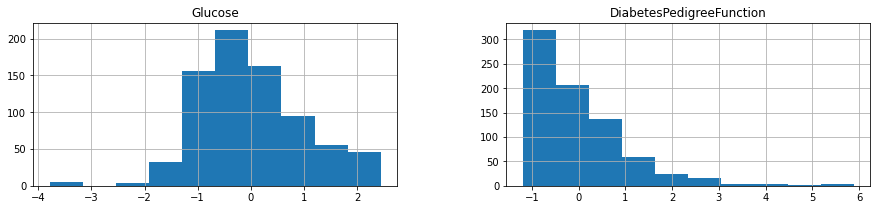

In [132]:
h=df[['Glucose','DiabetesPedigreeFunction']].hist(figsize=(15,3))
h

## 학습, 예측 데이터셋 나누기

8:2의 비율로 구하기 위해 전체 데이터의 행에서 80% 위치에 해당하는 값을 구해서 split_count라는 변수에 담는다.   
aha! dividing train and test data sets

In [189]:
split_count =int(df.shape[0] * 0.8)
split_count

614

train, test로 슬라이싱을 통해 데이터를 나눈다.

In [134]:
train = df[:split_count].copy() # 명시적 복사
train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Insulin_nan,Insulin_log,low_glu_insulin
0,6,0.848324,72,35,0,33.6,0.468492,50,1,False,169.5,5.138735,False
1,1,-1.123396,66,29,0,26.6,-0.365061,31,0,False,102.5,4.639572,False
2,8,1.943724,64,0,0,23.3,0.604397,32,1,True,169.5,5.138735,False
3,1,-0.998208,66,23,94,28.1,-0.920763,21,0,False,94.0,4.553877,True
4,0,0.504055,40,35,168,43.1,5.484909,33,1,False,168.0,5.129899,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,1,-0.309671,62,13,182,24.0,-1.008346,23,0,False,182.0,5.209486,False
610,3,-0.466156,54,21,158,30.9,-0.543248,24,0,False,158.0,5.068904,False
611,3,1.662050,58,22,194,32.9,0.365808,36,1,False,194.0,5.273000,False
612,7,1.474267,88,42,321,38.2,0.951711,40,1,True,321.0,5.774552,False


In [135]:
train.shape

(614, 13)

In [136]:
train = train[train['Insulin_nan'] < 600]

In [137]:
test = df[split_count:].copy()
test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Pregnancies_high,Insulin_nan,Insulin_log,low_glu_insulin
614,11,0.535352,74,26,144,36.1,0.257084,50,1,True,144.0,4.976734,False
615,3,-0.466156,72,0,0,25.8,-0.799958,27,0,False,102.5,4.639572,False
616,6,-0.121888,96,0,0,28.7,-0.950964,30,0,False,102.5,4.639572,False
617,2,-1.655448,62,13,15,20.1,-0.648952,23,0,False,15.0,2.772589,True
618,9,-0.278373,82,24,0,28.2,2.446670,50,1,True,169.5,5.138735,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,-0.622642,76,48,180,32.9,-0.908682,63,0,True,180.0,5.198497,False
764,2,0.034598,70,27,0,36.8,-0.398282,27,0,False,102.5,4.639572,False
765,5,0.003301,72,23,112,26.2,-0.685193,30,0,False,112.0,4.727388,False
766,1,0.159787,60,0,0,30.1,-0.371101,47,1,False,169.5,5.138735,False


## 학습, 예측에 사용할 컬럼

features_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져온다.

In [138]:
train.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'Pregnancies_high',
       'Insulin_nan', 'Insulin_log', 'low_glu_insulin'],
      dtype='object')

In [139]:
feature_names = list(train.columns)
feature_names.remove('Pregnancies')
feature_names.remove('Outcome')
#feature_names.remove('Age_low')
#feature_names.remove('Age_middle')
#feature_names.remove('Age_high')
feature_names.remove('Insulin')
feature_names.remove('Insulin_log')

In [140]:
feature_names

['Glucose',
 'BloodPressure',
 'SkinThickness',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Pregnancies_high',
 'Insulin_nan',
 'low_glu_insulin']

## 정답값이자 예측해야될 값

label_name이라는 변수에 예측할 컬럼의 이름을 담는다.

In [141]:
label_name = 'Outcome'
label_name #string

'Outcome'

## 학습, 예측 데이터셋 만들기

학습 세트 만들기. 시험의 기출문제와 같다

In [142]:
X_train = train[feature_names]

In [143]:
X_train.head()

,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_nan,low_glu_insulin
0,0.848324,72,35,33.6,0.468492,50,False,169.5,False
1,-1.123396,66,29,26.6,-0.365061,31,False,102.5,False
2,1.943724,64,0,23.3,0.604397,32,True,169.5,False
3,-0.998208,66,23,28.1,-0.920763,21,False,94.0,True
4,0.504055,40,35,43.1,5.484909,33,False,168.0,False


In [144]:
print(X_train.shape)
X_train.head()

(610, 9)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_nan,low_glu_insulin
0,0.848324,72,35,33.6,0.468492,50,False,169.5,False
1,-1.123396,66,29,26.6,-0.365061,31,False,102.5,False
2,1.943724,64,0,23.3,0.604397,32,True,169.5,False
3,-0.998208,66,23,28.1,-0.920763,21,False,94.0,True
4,0.504055,40,35,43.1,5.484909,33,False,168.0,False


정답 값 만들어주기. 기출문제의 정답!

In [145]:
y_train = train[label_name]

In [146]:
y_train.head() # diabetes : 1 not : 0
print(y_train.shape) # 열의 개수가 같아야함

(610,)


**문제는 대문자 X, 정답 값은 y X는 행렬로 되어 있고, y는 벡터 형태로 되어 있다. (???)**   
실전 시험 문제 만들기 test에서 

예측에 사용할 데이터 세트 만들기, 실전 시험 문제 만들기!

In [147]:
X_test = test[feature_names]
print(X_test.shape)
X_test.head()

(154, 9)


,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Pregnancies_high,Insulin_nan,low_glu_insulin
614,0.535352,74,26,36.1,0.257084,50,True,144.0,False
615,-0.466156,72,0,25.8,-0.799958,27,False,102.5,False
616,-0.121888,96,0,28.7,-0.950964,30,False,102.5,False
617,-1.655448,62,13,20.1,-0.648952,23,False,15.0,True
618,-0.278373,82,24,28.2,2.446670,50,True,169.5,False


train, test 모두 같은 column 내용과 개수를 가져야 함 이 경우 8개로 같음   
실전에 적용하기 전에 정답을 알고 있기 때문에 이 모델이 얼마나 좋은 성능을 가지는지 측정해야함   
예측의 정답값, 실전 시험 문제의 정답

In [148]:
y_test = test[label_name]
y_test

614    1
615    0
616    0
617    0
618    1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 154, dtype: int64

In [149]:
y_test.shape

(154,)

기출문제, 정답, 실전문제, 정답을 모두 만들어봤음   현실에서는 실전문제에 대한 정답은 모름. 여기에서는 데이터셋을 임의로 나눠서 학습이 잘 되는지 확인해보기 위해 채점할 때 이 값을 활용

## 머신러닝 알고리즘 가져오기

이 문제를 풀어보쟈

In [150]:
from sklearn.tree import DecisionTreeClassifier # 당뇨병인지 아닌지 분류하기 때문에 classify

model = DecisionTreeClassifier() # 알고리즘이 이미 구현된 것을 사용 - 요리할 때 완성된 조리도구를 사용하는 것
model # 다양한 옵션

DecisionTreeClassifier()

스무고개와 같은 알고리즘   동물인가? 사람인가? 질문에 꼬리를 물면서 데이터가 실제로 당뇨병인지 여부를 판단한다.   쇼핑몰 데이터라면, 이 사람이 물건을 구매하는지? 광고면 이 광고를 클릭하는지?   제조업. 이 제품 불량일까? 이를 예측, 분류하는 모델.

## 학습(훈련)

* 시험을 볼 때 기출문제(X_train)와 정답(y_train)을 보고 공부하는 과정과 유사하다.

In [151]:
#model.fit?

X : {array-like, sparse matrix} of shape (n_samples, n_features)   
    The training input samples. Internally, it will be converted to   
    ``dtype=np.float32`` and if a sparse matrix is provided   
    to a sparse ``csc_matrix``. **train data set**   

y : array-like of shape (n_samples,) or (n_samples, n_outputs)   
    The target values (class labels) as integers or strings. **answer set**

In [152]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

## 예측

* 실전 시험문제(X_train)라고 보면 된다. 우리가 정답을 직접 예측한다.

In [153]:
y_predict = model.predict(X_test) # 정답을 넣지 않음 다 풀고 채점해야지
y_predict[:5]

array([1, 0, 0, 0, 1], dtype=int64)

## 트리 알고리즘 분석하기

* 의사결정나무를 시각화합니다. 시각화해서 보기가 좋다.

[Text(183.52968750000002, 209.07692307692307, 'Insulin_nan <= 143.5\ngini = 0.453\nsamples = 610\nvalue = [399, 211]'),
 Text(110.43750000000001, 192.35076923076923, 'Insulin_nan <= 109.0\ngini = 0.163\nsamples = 380\nvalue = [346, 34]'),
 Text(83.7, 175.62461538461537, 'BMI <= 49.95\ngini = 0.098\nsamples = 329\nvalue = [312, 17]'),
 Text(79.05000000000001, 158.89846153846153, 'Glucose <= 0.958\ngini = 0.082\nsamples = 326\nvalue = [312, 14]'),
 Text(67.42500000000001, 142.1723076923077, 'Insulin_nan <= 99.5\ngini = 0.062\nsamples = 312\nvalue = [302, 10]'),
 Text(62.775000000000006, 125.44615384615385, 'Insulin_nan <= 95.5\ngini = 0.154\nsamples = 119\nvalue = [109, 10]'),
 Text(58.12500000000001, 108.72, 'BloodPressure <= 83.0\ngini = 0.127\nsamples = 117\nvalue = [109, 8]'),
 Text(37.2, 91.99384615384615, 'DiabetesPedigreeFunction <= 0.621\ngini = 0.088\nsamples = 108\nvalue = [103, 5]'),
 Text(18.6, 75.2676923076923, 'SkinThickness <= 31.5\ngini = 0.044\nsamples = 89\nvalue = [87,

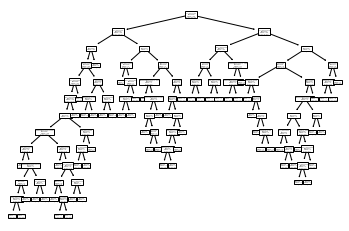

In [154]:
from sklearn.tree import plot_tree
#plot_tree?
plot_tree(
    model,
    feature_names=feature_names,)

글루코스의 특정 수치, 지니계수에 따라 샘플 개수가 나뉘게 된다. 

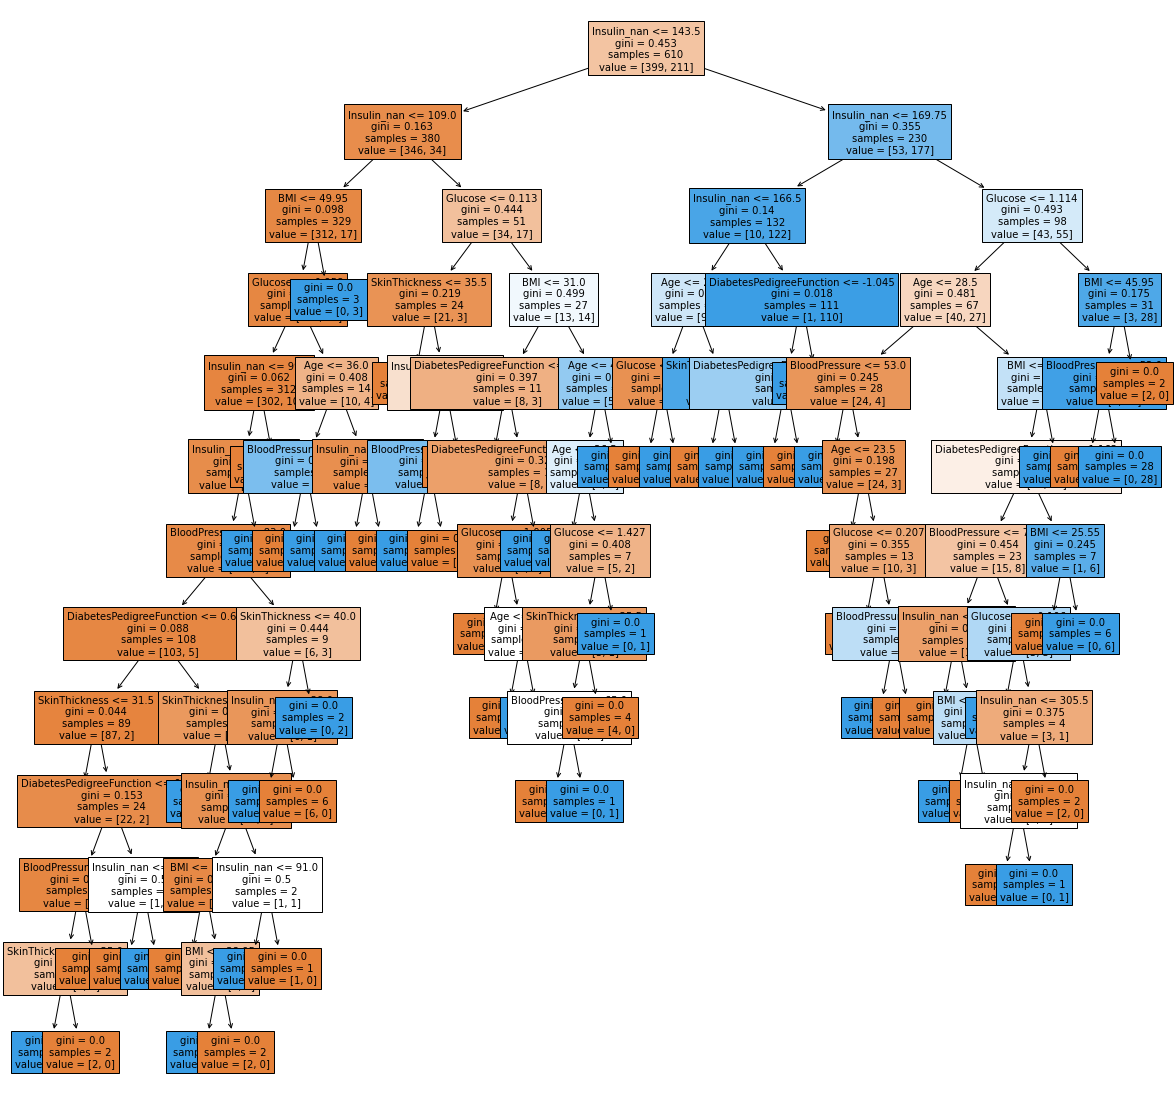

In [155]:
plt.figure(figsize=(20,20))
tree = plot_tree(
    model,
    feature_names=feature_names, filled=True, fontsize=10)

insulin 값이 가장 위에 있음! glucose가 가장 높게 나왔는데, 인슐린 결측치를 처리해주니 바뀜

In [156]:
#import graphviz from python.graphbiz
#from sklearn.tree import export_graphviz

#dot_tree = export_graphviz(model,
#                          feature_names = feature_names,
#                          filled=True)
#graphviz.Source(dot_tree)

Glucose 부터 TF로 나뉨, bmi tree를 타고 내려가면서 조건이 달라짐. 가장 위에 글루코스가 가장 좋은 조건이라는 뜻이고, 샘플의 수가 점점 줄어든다.

지니계수가 0이 되면 트리 그리기를 멈추고 당뇨가 맞다 아니다로 나누고, 트리를 깊게 내려갈 수록 training set에 맞추어 학습한 경향을 띄는데 이를 overfit이라함 이를 방지하기 위해 트리의 깊이를 제한한다. 의사결정트리는 예측이 쉬움.

피처의 중요도를 추출해본다.

In [157]:
model.feature_importances_

array([0.08867904, 0.04957561, 0.03507233, 0.07645751, 0.03146031,
       0.07729088, 0.        , 0.64146433, 0.        ])

피처의 중요도 시각화하기

<AxesSubplot:>

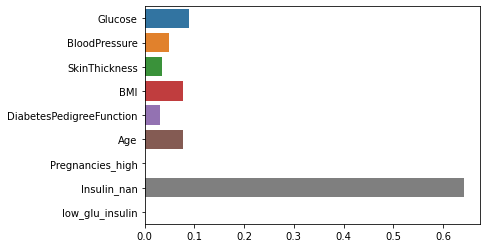

In [158]:
sns.barplot(x=model.feature_importances_, y=feature_names)

가장 좋은 조건이 Glucose!

## 정확도 측정하기

실제값 - 예측값을 빼주면 같은 값은 0으로 나오게 된다.   
여기에서 절대값을 씌운 값이 1인 값이 다르게 예측한 값이 된다.   
인슐린 결측치 평균으로 대체했더니 83점

In [118]:
y_predict

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0],
      dtype=int64)

In [119]:
diff_count = abs(y_test - y_predict).sum()
diff_count # 늘어났어 ㅋㅋㅋㅋㅋㅋㅋ 확연한 구분이 되지 않으면 정확도가 떨어짐...
# 44-> 39 -> 49(나이 범주화) -> 23(나이 범주화 ㄴㄴ 인슐린 결측치 평균값) -> 18(인슐린 결측치를 중앙값으로 대체)

17

현실세계에서는 답을 알지 못함. 서비스를 시행한 이후 쌓인 로그 데이터와 비교해야 한다.

In [120]:
abs(y_test - y_predict).sum() / len(y_test)

0.11038961038961038

예측의 정확도 구하기, 매번 예측할 때마다 다르게 예측함. 옵션에 다양한 값들이 들어가는데 랜덤임. 

In [121]:
diff_count = abs(y_test - y_predict).sum()

In [122]:
len(y_test) - diff_count # 맞힌 개수

137

전체에서 111개 맞추고, 백분위로 구하면

**직접 구하기**

In [123]:
(len(y_test) - diff_count) / len(y_test) * 100

88.96103896103897

**sklearn 모듈 사용**

In [124]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_predict) * 100

88.96103896103897

**model 내에서 자체 계산**

In [125]:
model.score(X_test, y_test) # 정답값을 알고 있을 때만 score로 구할 수 있음

0.8896103896103896

## 성능 높이기

### 수치형 변수를 범주형 변수로 만들어주기

### 정리 요약 - 결측치?   

연령대에 발병율을 보고 연령대에 해당되는 인슐린 수치
글루코스 수치 - 인슐린 수치 고려 등 더 정확도 올라감
아예 결측치 제외하는 방법 있음, 그러나 이를 제외하면 다른 데이터를 test에서 예측할 때 똑같이 제거해야되는데 결측치 값을 제거하면 인슐린 데이터 결측치가 많으면 제거할 상황 ㄴㄴ 특정 임의의 값으로 대체해주면 좋은 성능을 낸다. 다른 기법으로 시도를 해보자. 

### 정리 요약 - 로그(정규분포 만들기)?   
로그 처리를 하면 더 좋은 성능을 내기도. 여기서는 큰 차이가 없긴 하지만 시도해볼 수 있는 전처리 방법이다. log를 씌워주면 정규분포로 그려진다. 왼쪽꼬리 분포, 오른쪽 꼬리 분포보다 머신러닝이 학습하기 용이하다.

### 정리 요약 - 상관계수를 통한 파생변수?   
outcome 값 기준 글루코스 인슐린 100이하는 발병하지 않기 때문에 알려주는거임 머신러닝 알고리즘한테. 백지에서 넣어주는 데이터를 그대로 학습. 파생변수 만드는 것 : 우리가 알려주는 것 

### 정리 요약 - 이상치(Outlier) 다루기

### 정리 요약 - 스케일링   
변수, 숫자들 차이가 클 때 스케일링하면 높은 정확도를 가져옵니다.